In [1]:
from astropy.table import Table, join
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from astropy.coordinates import SkyCoord, match_coordinates_sky
import astropy.units as u
from matplotlib import cm
import time
from numpy.random import default_rng

import healpy as hp
import pymaster as nmt
import pandas as pd

import sys
sys.path.insert(0,'../code')
%load_ext autoreload
%autoreload 2
import utils
import generate_random
import correlations

In [2]:
matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['axes.labelsize'] = 22
matplotlib.rcParams['legend.fontsize'] = 18

matplotlib.rc('text', usetex=True)

In [3]:
rng = default_rng(seed=42)

## Load in data

In [9]:
NSIDE = 64
area_per_pixel = hp.pixelfunc.nside2pixarea(NSIDE, degrees=True)

In [10]:
fn_gaia = '../data/gaia_spz_kNN.fits'
tab_gaia = utils.load_table(fn_gaia)
N_data = len(tab_gaia)
ra_data, dec_data, gmag_data = tab_gaia['ra'], tab_gaia['dec'], tab_gaia['phot_g_mean_mag']
print(f"Number of data sources: {N_data}")

Number of data sources: 648842


In [11]:
map_nqso_data, pixel_indices_data = utils.get_map(NSIDE, ra_data, dec_data, null_val=0)

0.0 180.0 -180.0 180.0


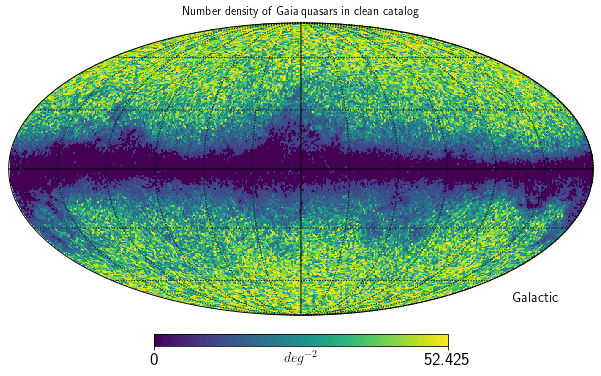

In [12]:
hp.mollview(
    map_nqso_data/area_per_pixel,
    title=rf"Number density of Gaia quasars in clean catalog",
    unit=r"$deg^{-2}$",
    norm="hist",
    cmap='viridis',
    coord=['C', 'G'],
    min=0,
    #max=10
)
hp.graticule()

# Load in randoms

In [13]:
col_names = ['fac_rand', 'dust', 'completeness', 'maskplane', 'maskmcs', 'maskdust', 'b_max', 'Av_max', 'NSIDE_dustmap']
rand_configs = [[1, False, False, False, False, False, None, None, None],
               [1, True, False, False, False, False, None, 0.2, 64],
               [1, True, False, False, False, True, None, 0.2, 64],
               [1, True, False, False, False, True, None, 0.2, 8]
               ] 
df_rconfigs = pd.DataFrame(data = rand_configs, 
                           columns = col_names)

In [14]:
def get_tabs_subsampled(df_rconfigs):
    tabs_r = []
    for i in range(len(df_rconfigs)):
        tag_rand = ''

        if df_rconfigs['dust'][i]:
            NSIDE_dustmap = int(df_rconfigs['NSIDE_dustmap'][i])
            tag_rand += f'_dust{NSIDE_dustmap}'
        if df_rconfigs['completeness'][i]:
            tag_rand += f'_completeness{gmag_comp}'
        fac_rand = df_rconfigs['fac_rand'][i]
        tab_r = utils.load_table(f'../data/randoms/random{tag_rand}_{fac_rand}x.fits')
        tabs_r.append(tab_r)
    return tabs_r

In [31]:
def get_tabs_masked(df_rconfigs):

    NSIDE_masks = 64
    R = 3.1

    tabs_rmask = []
    tabs_dmask = []

    for i in range(len(df_rconfigs)):
        b_max, NSIDE_dustmap, Av_max = None, None, None
        mask_plane, mask_mcs, mask_dust = False, False, False

        if df_rconfigs['maskplane'][i]:
            b_max = df_rconfigs['b_max'][i]
            mask_plane = True
            mask_title.append()
        if df_rconfigs['maskmcs'][i]:
            mask_mcs = True
        if df_rconfigs['maskdust'][i]:
            NSIDE_dustmap = int(df_rconfigs['NSIDE_dustmap'][i])
            Av_max = df_rconfigs['Av_max'][i]
            mask_dust = True

        tabs_r = get_tabs_subsampled(df_rconfigs)
            
        fn_dustmap = f'../data/dustmap_Avmean_NSIDE{NSIDE_dustmap}.npy'
        ra_rand, dec_rand = tabs_r[i]['ra'], tabs_r[i]['dec']
        ra_rmask, dec_rmask = generate_random.apply_masks(ra_rand, dec_rand, NSIDE_masks, NSIDE_dustmap,
                                        mask_plane=mask_plane, mask_mcs=mask_mcs, 
                                        mask_dust=mask_dust,
                                        fn_dustmap=fn_dustmap, b_max=b_max,
                                        Av_max=Av_max, R=R)
        tabs_rmask.append( Table([ra_rmask, dec_rmask], names=['ra', 'dec']) )

        # now apply same masks to data
        print(Av_max)
        ra_dmask, dec_dmask = generate_random.apply_masks(ra_data, dec_data, NSIDE_masks, NSIDE_dustmap,
                                        mask_plane=mask_plane, mask_mcs=mask_mcs, 
                                        mask_dust=mask_dust,
                                        fn_dustmap=fn_dustmap, b_max=b_max,
                                        Av_max=Av_max, R=R)
        tabs_dmask.append( Table([ra_dmask, dec_dmask], names=['ra', 'dec']) )
        
    stitles, mtitles = [], []
    for i in range(len(df_rconfigs)):
        subsample_title, mask_title = get_title(df_rconfigs.iloc[i])
        stitles.append(subsample_title)
        mtitles.append(mask_title)
    df_rconfigs['subsample_title'] = stitles
    df_rconfigs['mask_title'] = mtitles
        
    return tabs_dmask, tabs_rmask

In [16]:
def get_title(df_row):
    if df_row['dust'] or df_row['completeness']:
        subsample_title = 'Subsample by'
    else:
        subsample_title = 'Uniform '
        
    if df_row['dust']:
        NSIDE_dustmap = int(df_row['NSIDE_dustmap'])
        subsample_title += f' dust (NSIDE={NSIDE_dustmap}),'
    if df_row['completeness']:
        subsample_title += ' completeness,'
    subsample_title = subsample_title[:-1]+'.'
    
    if df_row['maskplane'] or df_row['maskmcs'] or df_row['maskdust']:
        mask_title = 'Masked by'
    else:
        mask_title = ' '
        
    if df_row['maskplane']:
        b_max = df_rconfigs['b_max']
        mask_title += f' plane (b_max={b_max}),'
    if df_row['maskmcs']:
        mask_title += f' MCs,'
    if df_row['maskdust']:
        NSIDE_dustmap = int(df_row['NSIDE_dustmap'])
        Av_max = df_row['Av_max']
        mask_title += f' dust (NSIDE={NSIDE_dustmap}, Av_max={Av_max}),'
    mask_title = mask_title[:-1]+'.'

    return subsample_title, mask_title

In [17]:
tabs_dmask, tabs_rmask = get_tabs_masked(df_rconfigs)

64 3.1 ../data/dustmap_Avmean_NSIDE64.npy
Dustmap already exists, loading from ../data/dustmap_Avmean_NSIDE64.npy
Applied mask, kept 0.676 of sources
64 3.1 ../data/dustmap_Avmean_NSIDE64.npy
Dustmap already exists, loading from ../data/dustmap_Avmean_NSIDE64.npy
Applied mask, kept 0.708 of sources
8 3.1 ../data/dustmap_Avmean_NSIDE8.npy
Dustmap already exists, loading from ../data/dustmap_Avmean_NSIDE8.npy
Applied mask, kept 0.631 of sources
8 3.1 ../data/dustmap_Avmean_NSIDE8.npy
Dustmap already exists, loading from ../data/dustmap_Avmean_NSIDE8.npy
Applied mask, kept 0.672 of sources


In [18]:
NSIDE = 64
area_per_pixel = hp.pixelfunc.nside2pixarea(NSIDE, degrees=True)

0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0


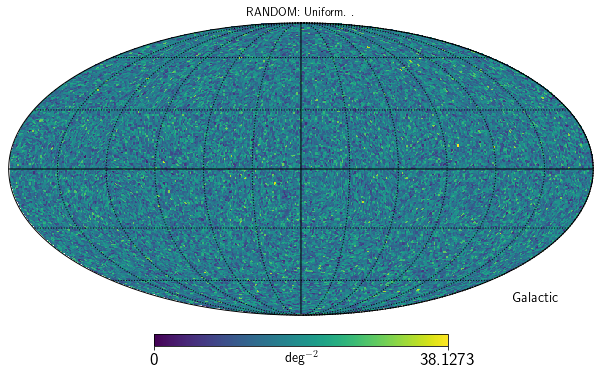

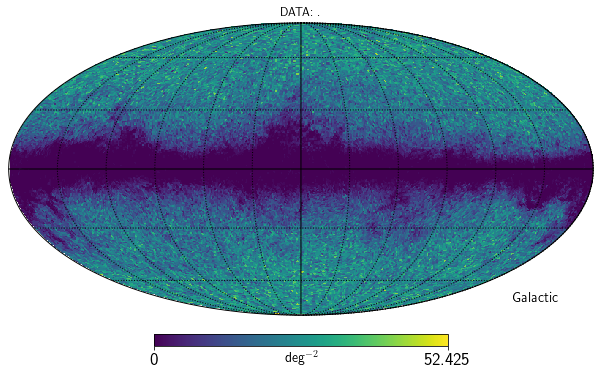

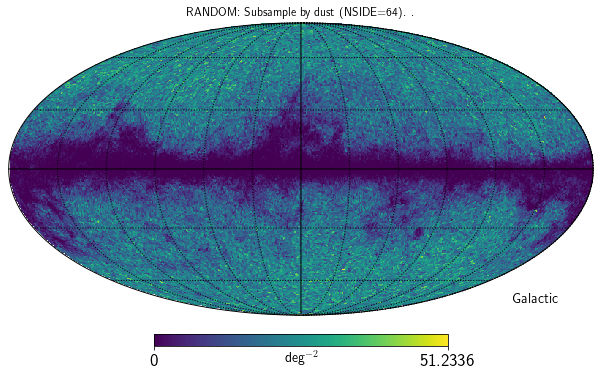

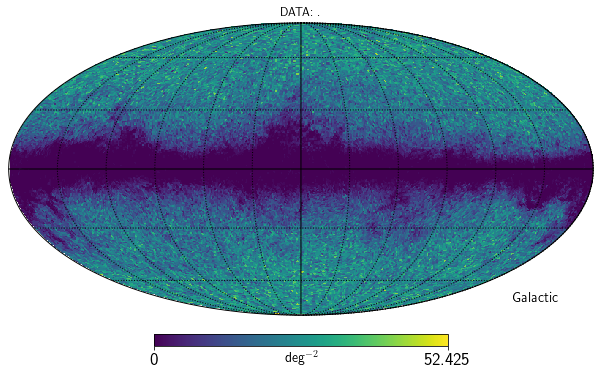

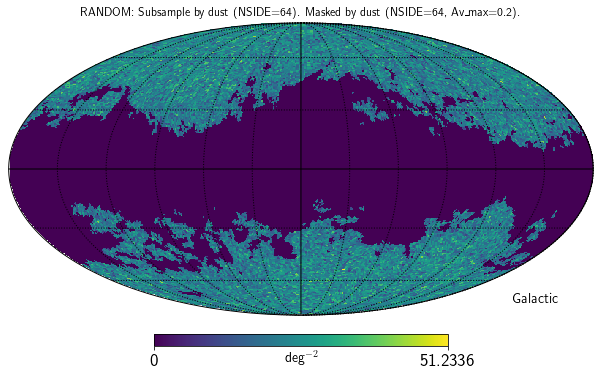

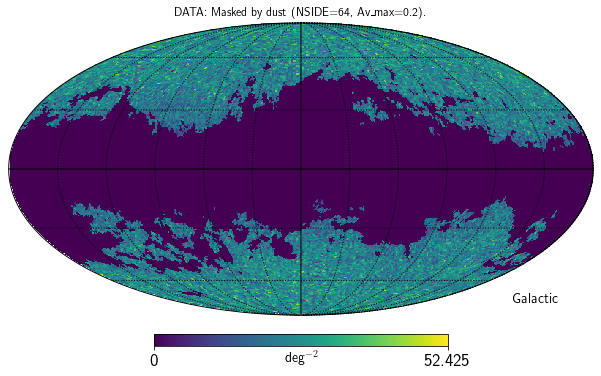

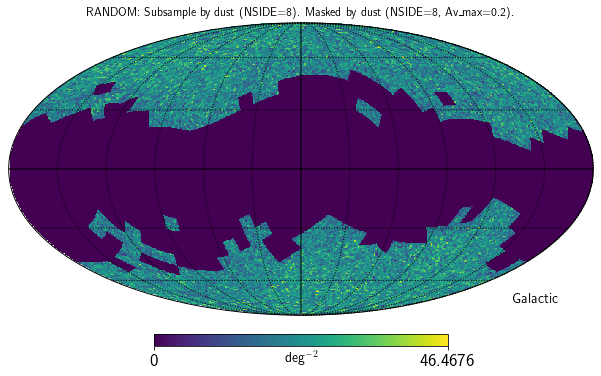

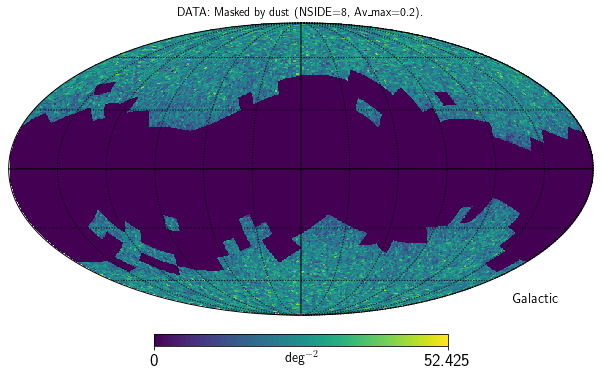

In [19]:
for i in range(len(tabs_rmask)):
        
    map_nqso_r, pixel_indices_r = utils.get_map(NSIDE, tabs_rmask[i]['ra'], tabs_rmask[i]['dec'], null_val=0)
    title_r = 'RANDOM: ' + df_rconfigs['subsample_title'][i] + ' ' + df_rconfigs['mask_title'][i]
    hp.mollview(map_nqso_r/area_per_pixel, title=title_r, unit=r"deg$^{-2}$",
                cmap='viridis', coord=['C', 'G'], min=0)
    hp.graticule()
    
    map_nqso_d, pixel_indices_d = utils.get_map(NSIDE, tabs_dmask[i]['ra'], tabs_dmask[i]['dec'], null_val=0)    
    title_d = 'DATA: ' + df_rconfigs['mask_title'][i]
    hp.mollview(map_nqso_d/area_per_pixel, title=title_d, unit=r"deg$^{-2}$",
                cmap='viridis', coord=['C', 'G'], min=0)
    hp.graticule()

## w(theta)

In [20]:
nbins = 12
theta_edges_log = np.logspace(-1, 1, nbins + 1)
theta_avg_log = 10**(0.5*(np.log10(theta_edges_log[:-1]) + np.log10(theta_edges_log[1:])))
print(theta_edges_log)

[ 0.1         0.14677993  0.21544347  0.31622777  0.46415888  0.68129207
  1.          1.46779927  2.15443469  3.16227766  4.64158883  6.81292069
 10.        ]


In [21]:
wthetas_log = []
for i in range(len(tabs_rmask)):
    wtheta_log = correlations.compute_wtheta(theta_edges_log, tabs_dmask[i]['ra'], tabs_dmask[i]['dec'], 
                                                             tabs_rmask[i]['ra'], tabs_rmask[i]['dec'])
    wthetas_log.append(wtheta_log)

[Warning] The CPU supports AVX2 but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports AVX but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports SSE4.2 but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports SSE4.1 but the compiler does not.  Can you try another compiler?
/Users/ksf/miniconda3/envs/gaiaenv/lib/python3.10/site-packages/Corrfunc/utils.py:918: UserWarning: One or more input array has non-native endianness!  A copy will be made with the correct endianness.
  warnings.warn("One or more input array has non-native endianness!  A copy will"\


Time: 6.5776 s
Time: 10.6935 s
Time: 5.4263 s
Time: 7.0879 s
Time: 14.0476 s
Time: 7.2151 s
Time: 5.8076 s
Time: 10.7292 s
Time: 4.8283 s
Time: 5.2131 s
Time: 10.0238 s
Time: 5.5593 s


In [54]:
pixel_size_8 = hp.nside2resol(8, arcmin=True)/60
pixel_size_64 = hp.nside2resol(64, arcmin=True)/60

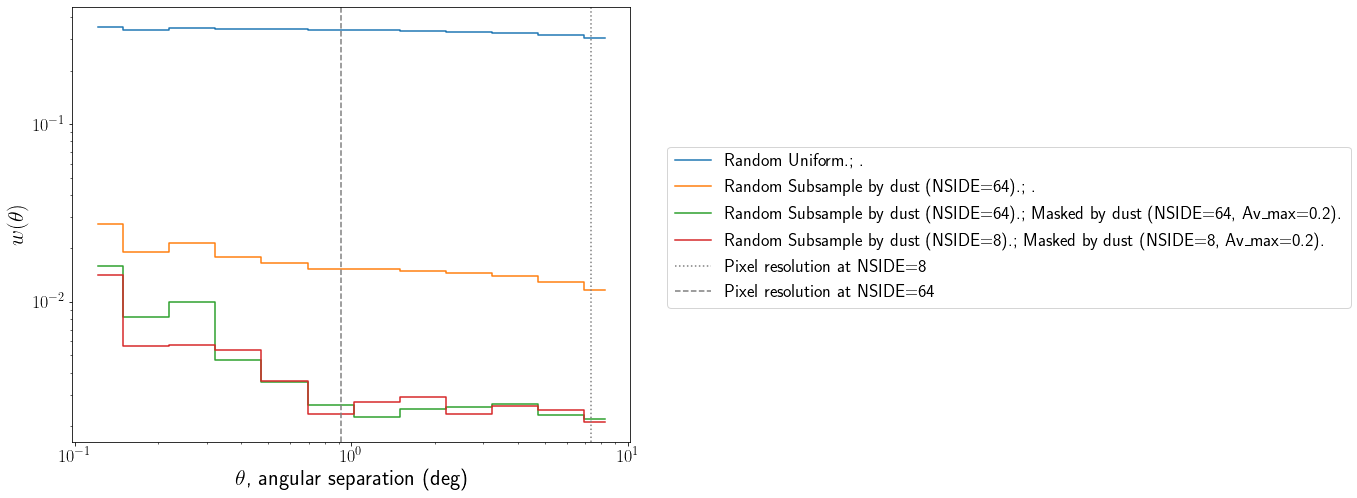

In [55]:
plt.figure(figsize=(10,8))
for i in range(len(wthetas_log)):
    plt.step(theta_avg_log, wthetas_log[i], where='mid', 
             label=f"Random {df_rconfigs['subsample_title'][i]}; {df_rconfigs['mask_title'][i]}")
    
plt.axvline(pixel_size_8, label='Pixel resolution at NSIDE=8', color='grey', ls=':')
plt.axvline(pixel_size_64, label='Pixel resolution at NSIDE=64', color='grey', ls='--')

plt.xlabel(r'$\theta$, angular separation (deg)')
plt.ylabel(r'$w(\theta)$')
plt.xscale('log')
plt.yscale('log')
plt.axhline(0, color='grey', lw=0.8)
plt.legend(bbox_to_anchor=(1.05, 0.7))

## dust cuts

In [40]:
col_names = ['fac_rand', 'dust', 'completeness', 'maskplane', 'maskmcs', 'maskdust', 'b_max', 'Av_max', 'NSIDE_dustmap']
rand_configs_Avcuts = [[1, True, False, False, False, True, None, 0.2, 64],
                       [1, True, False, False, False, True, None, 0.3, 64],
                       [1, True, False, False, False, True, None, 0.4, 64],
                       [1, True, False, False, False, True, None, 0.5, 64],
                       [1, True, False, False, False, True, None, 100, 64],
                       ] 
df_rconfigs_Avcuts = pd.DataFrame(data = rand_configs_Avcuts, 
                               columns = col_names)

In [61]:
col_names = ['fac_rand', 'dust', 'completeness', 'maskplane', 'maskmcs', 'maskdust', 'b_max', 'Av_max', 'NSIDE_dustmap']
rand_configs_Avcuts_nodustsub = [[1, False, False, False, False, True, None, 0.2, 64],
                             [1, False, False, False, False, True, None, 0.3, 64],
                             [1, False, False, False, False, True, None, 0.4, 64],
                             [1, False, False, False, False, True, None, 0.5, 64],
                             [1, False, False, False, False, True, None, 100, 64],
                             ] 
df_rconfigs_Avcuts_nodustsub = pd.DataFrame(data = rand_configs_Avcuts_nodustsub, 
                               columns = col_names)

In [41]:
tabs_dmask_Avcuts, tabs_rmask_Avcuts = get_tabs_masked(df_rconfigs_Avcuts)

64 3.1 ../data/dustmap_Avmean_NSIDE64.npy
Dustmap already exists, loading from ../data/dustmap_Avmean_NSIDE64.npy
Applied mask, kept 0.676 of sources
0.2
64 3.1 ../data/dustmap_Avmean_NSIDE64.npy
Dustmap already exists, loading from ../data/dustmap_Avmean_NSIDE64.npy
Applied mask, kept 0.708 of sources
64 3.1 ../data/dustmap_Avmean_NSIDE64.npy
Dustmap already exists, loading from ../data/dustmap_Avmean_NSIDE64.npy
Applied mask, kept 0.810 of sources
0.3
64 3.1 ../data/dustmap_Avmean_NSIDE64.npy
Dustmap already exists, loading from ../data/dustmap_Avmean_NSIDE64.npy
Applied mask, kept 0.841 of sources
64 3.1 ../data/dustmap_Avmean_NSIDE64.npy
Dustmap already exists, loading from ../data/dustmap_Avmean_NSIDE64.npy
Applied mask, kept 0.880 of sources
0.4
64 3.1 ../data/dustmap_Avmean_NSIDE64.npy
Dustmap already exists, loading from ../data/dustmap_Avmean_NSIDE64.npy
Applied mask, kept 0.906 of sources
64 3.1 ../data/dustmap_Avmean_NSIDE64.npy
Dustmap already exists, loading from ../data/d

In [62]:
tabs_dmask_Avcuts_nodustsub, tabs_rmask_Avcuts_nodustsub = get_tabs_masked(df_rconfigs_Avcuts_nodustsub)

64 3.1 ../data/dustmap_Avmean_NSIDE64.npy
Dustmap already exists, loading from ../data/dustmap_Avmean_NSIDE64.npy
Applied mask, kept 0.475 of sources
0.2
64 3.1 ../data/dustmap_Avmean_NSIDE64.npy
Dustmap already exists, loading from ../data/dustmap_Avmean_NSIDE64.npy
Applied mask, kept 0.708 of sources
64 3.1 ../data/dustmap_Avmean_NSIDE64.npy
Dustmap already exists, loading from ../data/dustmap_Avmean_NSIDE64.npy
Applied mask, kept 0.592 of sources
0.3
64 3.1 ../data/dustmap_Avmean_NSIDE64.npy
Dustmap already exists, loading from ../data/dustmap_Avmean_NSIDE64.npy
Applied mask, kept 0.841 of sources
64 3.1 ../data/dustmap_Avmean_NSIDE64.npy
Dustmap already exists, loading from ../data/dustmap_Avmean_NSIDE64.npy
Applied mask, kept 0.663 of sources
0.4
64 3.1 ../data/dustmap_Avmean_NSIDE64.npy
Dustmap already exists, loading from ../data/dustmap_Avmean_NSIDE64.npy
Applied mask, kept 0.906 of sources
64 3.1 ../data/dustmap_Avmean_NSIDE64.npy
Dustmap already exists, loading from ../data/d

0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0


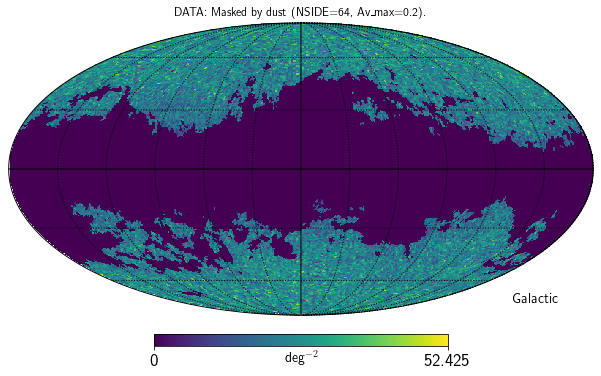

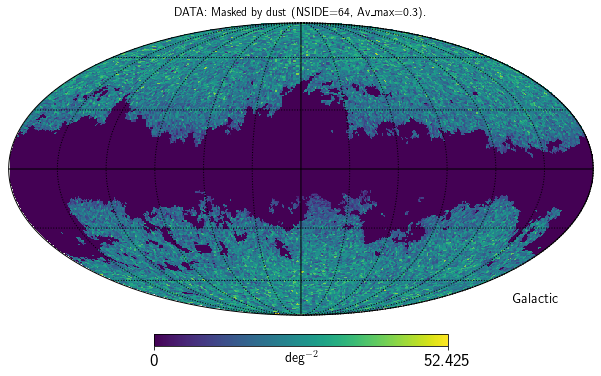

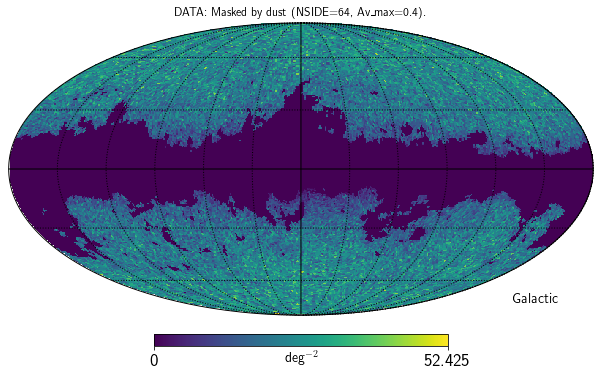

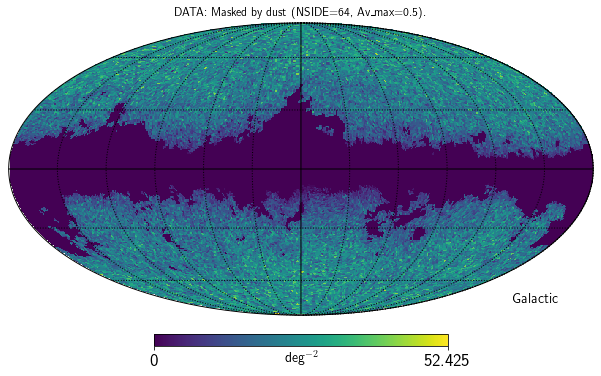

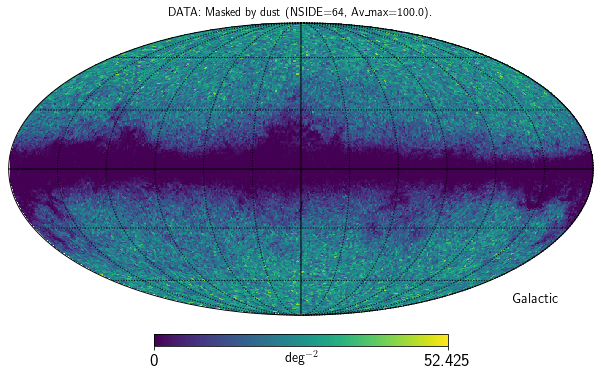

In [42]:
for i in range(len(tabs_dmask_Avcuts)):
    
    map_nqso_d, pixel_indices_d = utils.get_map(NSIDE, tabs_dmask_Avcuts[i]['ra'], tabs_dmask_Avcuts[i]['dec'], 
                                                null_val=0)    
    title_d = 'DATA: ' + df_rconfigs_Avcuts['mask_title'][i]
    hp.mollview(map_nqso_d/area_per_pixel, title=title_d, unit=r"deg$^{-2}$",
                cmap='viridis', coord=['C', 'G'], min=0)
    hp.graticule()

In [59]:
wthetas_Avcuts_log = []
for i in range(len(tabs_rmask_Avcuts)):
    wthetas_Avcuts_log.append( correlations.compute_wtheta(theta_edges_log, 
                                                           tabs_dmask_Avcuts[i]['ra'], tabs_dmask_Avcuts[i]['dec'], 
                                                           tabs_rmask_Avcuts[i]['ra'], tabs_rmask_Avcuts[i]['dec']) )

/Users/ksf/miniconda3/envs/gaiaenv/lib/python3.10/site-packages/Corrfunc/utils.py:918: UserWarning: One or more input array has non-native endianness!  A copy will be made with the correct endianness.
  warnings.warn("One or more input array has non-native endianness!  A copy will"\


Time: 4.5632 s
Time: 8.9758 s
Time: 4.5456 s
Time: 5.9900 s
Time: 15.0065 s
Time: 9.6665 s
Time: 9.1666 s
Time: 16.8124 s
Time: 8.0467 s
Time: 9.5886 s
Time: 15.9510 s
Time: 8.5144 s
Time: 8.5572 s
Time: 15.4166 s
Time: 7.8331 s


In [63]:
wthetas_Avcuts_nodustsub_log = []
for i in range(len(tabs_rmask_Avcuts)):
    wthetas_Avcuts_nodustsub_log.append( correlations.compute_wtheta(theta_edges_log, 
                                            tabs_dmask_Avcuts_nodustsub[i]['ra'], tabs_dmask_Avcuts_nodustsub[i]['dec'], 
                                            tabs_rmask_Avcuts_nodustsub[i]['ra'], tabs_rmask_Avcuts_nodustsub[i]['dec']) )

/Users/ksf/miniconda3/envs/gaiaenv/lib/python3.10/site-packages/Corrfunc/utils.py:918: UserWarning: One or more input array has non-native endianness!  A copy will be made with the correct endianness.
  warnings.warn("One or more input array has non-native endianness!  A copy will"\


Time: 4.8285 s
Time: 6.1095 s
Time: 2.1805 s
Time: 6.0206 s
Time: 8.0217 s
Time: 2.8737 s
Time: 6.6800 s
Time: 9.3630 s
Time: 3.4466 s
Time: 7.2009 s
Time: 10.6340 s
Time: 3.9695 s
Time: 7.7551 s
Time: 14.9307 s
Time: 8.3279 s


In [ ]:
colors = ['red', 'orange', 'green', 'blue', 'purple']
plt.figure(figsize=(10,8))
for i in range(len(wthetas_Avcuts_log)):
    plt.step(theta_avg_log, wthetas_Avcuts_log[i], where='mid', colors=colors[i],
             label=f"Random {df_rconfigs_Avcuts['subsample_title'][i]}; {df_rconfigs_Avcuts['mask_title'][i]}")
    plt.step(theta_avg_log, wthetas_Avcuts_nodustsub_log[i], where='mid', colors=colors[i], ls='--',
             label=f"Random {df_rconfigs_Avcuts_nodustsub['subsample_title'][i]}; {df_rconfigs_Avcuts['mask_title'][i]}")
plt.xlabel(r'$\theta$, angular separation (deg)')
plt.ylabel(r'$w(\theta)$')
plt.xscale('log')
plt.yscale('log')
plt.axhline(0, color='grey', lw=0.8)
plt.legend(bbox_to_anchor=(1.05, 0.7))